# CS 536 : Pruning Decision Trees Assignment
by Sagar Jain (sj735)

In [32]:
#Importing libraries
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7]

In [28]:
#Initializing global variables
k = 20 # so at to take i values from 0-20
m = 30
epsilon = 0.0000001

# Answer 1

Write a function to generate m samples of (X, Y ), and another to fit a tree to that data using ID3. Write a
third function to, given a decision tree f, estimate the error rate of that decision tree on the underlying data,
err(f). Do this repeatedly for a range of m values, and plot the ‘typical’ error of a tree trained on m data
points as a function of m. Does this agree with your intuition?

Function to generate dataset >>

In [41]:
def dataframe_function(k=0, m=0):
    
    data = []
    
    #Internal function to generate rows
    def vector_generation_function(k=0):
        X = []
        Y = 0
        

        for x in range(0, k+1):
            if x >= 1 and x <= 14:
                prev_X = X[-1]
                X.append(int(np.random.choice([prev_X, 1-prev_X], 1, p=[0.75, 0.25])))
            else: # when x == 1
                X.append(int(np.random.choice([1,0], 1, p=[0.5, 0.5])))

        if X[0] == 0:
            counts = np.bincount(X[1:7])
            X.append(np.argmax(counts))
        else:
            counts = np.bincount(X[8:14])
            X.append(np.argmax(counts))

        return X
    
    for x in range(1, m+1):
        data.append(vector_generation_function(k))
        
    #Create header list
    headers = ['X'+str(x) for x in range(0,k+1)] + ['Y']
    
    dataframe = pd.DataFrame(data, columns=headers)
        
    return dataframe

Function to calculate Information Gain >>

In [38]:
def information_gain(subset_dataframe):
        
        classes = list(subset_dataframe)
        x0_y0 = len(subset_dataframe.loc[(subset_dataframe[classes[0]] == 0) & (subset_dataframe[classes[1]] == 0)])
        
        x0_y1 = len(subset_dataframe.loc[(subset_dataframe[classes[0]] == 0) & (subset_dataframe[classes[1]] == 1)])
        
        x1_y0 = len(subset_dataframe.loc[(subset_dataframe[classes[0]] == 1) & (subset_dataframe[classes[1]] == 0)])
        
        x1_y1 = len(subset_dataframe.loc[(subset_dataframe[classes[0]] == 1) & (subset_dataframe[classes[1]] == 1)])
                
        py0 = (x0_y0 + x1_y0) / (x0_y0 + x1_y0 + x0_y1 + x1_y1 + epsilon)
        
        py1 = (x0_y1 + x1_y1) / (x0_y0 + x1_y0 + x0_y1 + x1_y1 + epsilon)
        
        px0 = (x0_y0 + x0_y1) / (x0_y0 + x1_y0 + x0_y1 + x1_y1 + epsilon)
        
        px1 = (x1_y0 + x1_y1) / (x0_y0 + x1_y0 + x0_y1 + x1_y1 + epsilon)
                
        py0_x0 = x0_y0 / (x0_y0 + x0_y1 + epsilon)
        
        py1_x0 = x0_y1 / (x0_y0 + x0_y1 + epsilon)
        
        py0x1 = x1_y0 / (x1_y0 + x1_y1 + epsilon)
        
        py1x1 = x1_y1 / (x1_y0 + x1_y1 + epsilon)
              
        pyx0 = (-1 * py0_x0 * np.log(py0_x0 + epsilon)) + (-1 * py1_x0 * np.log(py1_x0 + epsilon))
        
        pyx1 = (-1 * py0x1 * np.log(py0x1 + epsilon)) + (-1 * py1x1 * np.log(py1x1 + epsilon))
                
        hy =  (-1 * py0 * np.log(py0 + epsilon)) + (-1 * py1 * np.log(py1 + epsilon))
        hyx = (px1 * pyx1) + (px0 * pyx0)
                
        igx = hy - hyx
                
        return igx

Function to split feature based on Entropy ....
Splitting Variable function :

In [5]:
def splitting_variable(dataframe):
    """This function take a dataframe as input and returns apt splitting variable based on maximum information gain"""
    
    
    #Fetch information gain for every X
    columns = list(dataframe)
    ig = [information_gain(dataframe[[x, 'Y']]) for x in columns[:-1]]
    split_on_variable = columns[np.argmax(ig)]
    
    return split_on_variable #splitting variable

Function to split feature based on Chi-Squared test 

In [6]:
#Splitting function based on Chi-Squared Test
def chi_squared_split(dataframe):
    
    def chi_squared_function(subset_df):
        """Extract the count when
               | x=0  | x=1
           y=0 | x0y0 | x1y0
           y=1 | x0y1 | x1y1
        """
        classes = list(subset_df)
        x0y0 = len(subset_df.loc[(subset_df[classes[0]] == 0) & (subset_df[classes[1]] == 0)])
        x0y1 = len(subset_df.loc[(subset_df[classes[0]] == 0) & (subset_df[classes[1]] == 1)])
        x1y0 = len(subset_df.loc[(subset_df[classes[0]] == 1) & (subset_df[classes[1]] == 0)])
        x1y1 = len(subset_df.loc[(subset_df[classes[0]] == 1) & (subset_df[classes[1]] == 1)])
        
        total_count = x0y0 + x0y1 + x1y0 + x1y1
        
        py0 = (x0y0 + x1y0) / (total_count + epsilon)
        py1 = (x0y1 + x1y1) / (total_count + epsilon)
        
        px0 = (x0y0 + x0y1) / (total_count + epsilon)
        px1 = (x1y0 + x1y1) / (total_count + epsilon)
        
        t_x0y0 = (((px0 * py0 * total_count) - x0y0) ** 2)/((px0 * py0 * total_count) + epsilon) 
        t_x0y1 = (((px0 * py1 * total_count) - x0y1) ** 2)/((px0 * py1 * total_count) + epsilon)
        t_x1y0 = (((px1 * py0 * total_count) - x1y0) ** 2)/((px1 * py0 * total_count) + epsilon)
        t_x1y1 = (((px1 * py1 * total_count) - x1y1) ** 2)/((px1 * py1 * total_count) + epsilon)
        
        T = t_x0y0 + t_x0y1 + t_x1y0 + t_x1y1
        
        return T
        
    #Fetch information gain for every X
    columns = list(dataframe)
    chi = [chi_squared_function(dataframe[[x, 'Y']]) for x in columns[:-1]]

    split_on_variable = columns[np.argmax(chi)]
    
    return split_on_variable, chi[np.argmax(chi)] #splitting variable

Function to generate decision tree based on ID3 algorithm

In [21]:
#generate decision tree
def generate_decision_tree(dataframe, tree=None):
    
    #fetch the features X1, X2...Xn
    classes = list(dataframe)[:-1]
    
    #get the node to split on
    split_var = splitting_variable(dataframe)
    
    #initialize tree in form of dictionary if not already initialized
    if tree is None:
        tree = {}
        tree[split_var] = {}
    
    #Explore when split_var is 0 & 1
    for value in (0,1):
        split_dataframe = dataframe[dataframe[split_var] == value]
        class_value, value_count = np.unique(split_dataframe['Y'], return_counts=True)
        
        #check if split_dataframe has only single class to consider, if not then explore further
        if len(value_count) == 1: 
            tree[split_var][value] = class_value[0]
        else:
            #recursively call the tree
            tree[split_var][value] = generate_decision_tree(split_dataframe)
            
    #return the generated tree
    return tree        

In [22]:
#predict function using the decision tree
def predict(X_dataframe, tree):
    for value in tree.keys():
        sub_tree = int(X_dataframe[value])
        
        try:           
            tree = tree[value][sub_tree]
        except KeyError:
            return sub_tree
        
        if type(tree) is not dict:
            return tree
        else:
            return predict(X_dataframe, tree)

In [23]:
#Create function for computing ERR_train
def compute_ERR(dataframe, tree):
    
    err = 0
    length = len(dataframe)
    
    for row_index in range(0, length):
        row = dataframe[row_index: row_index+1]
        
        try:
            if 'Y' not in tree.keys() and int(row['Y']) != predict(row, tree):
                err += 1

            elif int(row['Y']) != tree['Y']:
                err += 1
        except:
            pass
            
    return err/length

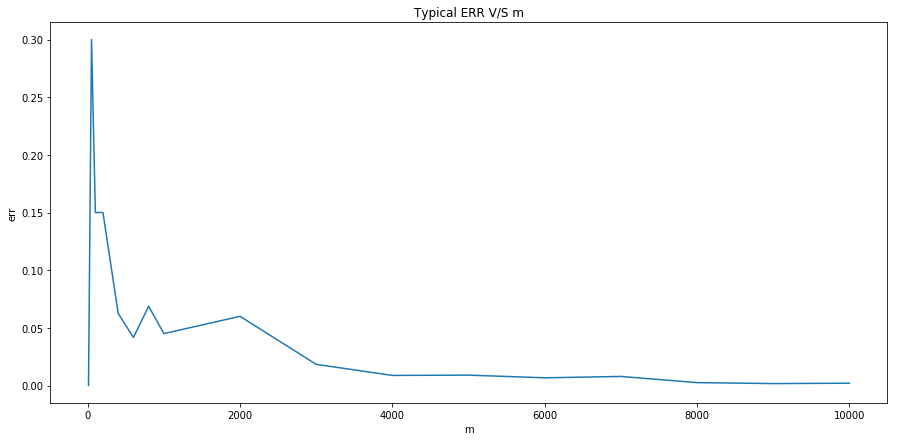

In [34]:
k = 20
m = [10, 50, 100, 200, 400, 600, 800, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
split_ratio = 0.8
err = {}

for values in m:
    df = dataframe_function(k, values)
    train_df = df.iloc[:int(split_ratio*values)]
    test_df = df.iloc[int(split_ratio*values):]
    
    tree = generate_decision_tree(train_df)
    
    ERR = compute_ERR(test_df, tree)
    
    err[values] = ERR
    
err_list = sorted(err.items())
x,y = zip(*err_list)

plt.plot(x,y)
plt.title('Typical ERR V/S m')
plt.xlabel('m')
plt.ylabel('err')
plt.show()

# Conclusion
We can see that as the data set increases, typical error decreases. But after a point in m value the error rate does not improve much. As there is not much significant improvement in error rate from m = 7000 to m = 10000.

# Answer 2

Note that X15 through X20 are completely irrelevant to predicting the value of Y . For a range of m values,
repeatedly generate data sets of that size and fit trees to that data, and estimate the average number of
irrelevant variables that are included in the fit tree. How much data would you need, typically, to avoid fitting
on this noise?

In [36]:
#Check for irrelevant variables
def get_irrelv_var_count(decision_tree_generator = generate_decision_tree):
    irrelevant = ["'X15'", "'X16'", "'X17'", "'X18'", "'X19'", "'X20'"]
    k = 20
    #m = [10, 50, 100, 200, 400, 600, 800, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
    m = [1000, 5000, 50000, 100000, 500000]
    split_ratio = 0.8
    irr_count = {}

    for values in m:
        df = dataframe_function(k, values)
        train_df = df.iloc[:int(split_ratio*values)]
        test_df = df.iloc[int(split_ratio*values):]

        tree = decision_tree_generator(train_df)

        #count irrelevant variable in current decision tree
        variable_list = str(tree)
        count = 0
        for irr in irrelevant:
            if irr in variable_list:
                count += 1

        irr_count[values] = count

    irr_list = sorted(irr_count.items())
    x,y = zip(*irr_list)

    plt.plot(x,y)
    plt.title('Irrelevant Variables V/S m')
    plt.xlabel('m')
    plt.ylabel('irrelevant var')
    plt.show()

    average_irrelevant_variable = sum(y)/len(y)
    print('Average number of Irrelevant Variables: ', average_irrelevant_variable)
    
    return average_irrelevant_variable

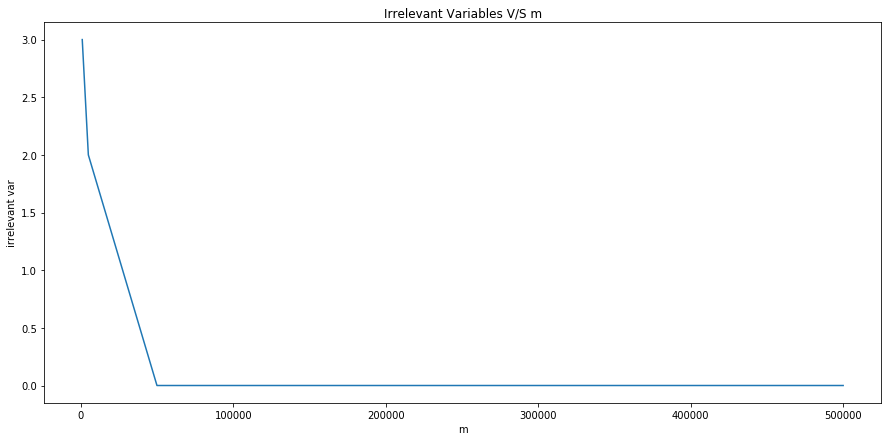

Average number of Irrelevant Variables:  1.0


1.0

In [37]:
get_irrelv_var_count()

# Conclusion
On an average we are getting around 1-2 irrelevant variable when m is 50000 and as the value of m increases the count of irrelevant variables in our decision tree goes down to 0

# Answer 3

Generate a data set of size m = 10000, and set aside 8000 points for training, and 2000 points for testing. The
remaining questions should all be applied to this data set.

Part a)

**Pruning by Depth:** Consider growing a tree as a process - running ID3 for instance until all splits
up to depth d have been performed. Depth d = 0 should correspond to no decisions - a prediction for Y
is made just on the raw frequencies of Y in the data. Plot, as a function of d, the error on the training
set and the error on the test set for a tree grown to depth d. What does your data suggest as a good
threshold depth?

In [39]:
#generate decision tree using pruning by depth
def depth_pruning_decision_tree(dataframe, tree=None, depth=0, count=0):
     
    """print(depth)"""
    
    #fetch the features X1, X2...Xn
    classes = list(dataframe)[:-1]
    
    #get the node to split on
    split_var = splitting_variable(dataframe)
    
    #initialize tree in form of dictionary if not already initialized
    if tree is None:
        tree = {}
        tree[split_var] = {}
    
    if depth == 0 and count == 0:
        tree = {}
        counts = np.bincount(dataframe['Y'])
        if counts[0] == counts[1]:
            tree['Y'] = int(np.random.choice([1,0], 1, p=[0.5, 0.5]))
        else:
            tree['Y'] = np.argmax(counts)
        return tree
        
    #Explore when split_var is 0 & 1
    for value in (0,1):
        split_dataframe = dataframe[dataframe[split_var] == value]
        class_value, value_count = np.unique(split_dataframe['Y'], return_counts=True)
        
        #check if split_dataframe has only single class to consider, if not then explore further
        if len(value_count) == 1: 
            tree[split_var][value] = class_value[0]
        else:
            #recursively call the tree
            if depth == 0:
                """print(split_var)
                print(split_dataframe)"""
                counts = np.bincount(split_dataframe['Y'])
                if counts[0] == counts[1]:
                    tree[split_var][value] = int(np.random.choice([1,0], 1, p=[0.5, 0.5]))
                else:
                    tree[split_var][value] = np.argmax(counts)
                break
            tree[split_var][value] = depth_pruning_decision_tree(split_dataframe, depth=depth-1, count=count+1)
            
    #return the generated tree
    return tree 

In [42]:
pprint(depth_pruning_decision_tree(dataframe_function(k=20, m=100), depth=2))

{'X3': {0: {'X1': {0: {'X0': {0: 0, 1: 0}}, 1: {'X11': {0: 0, 1: 1}}}},
        1: {'X10': {0: {'X6': {0: 0, 1: 0}}, 1: {'X5': {0: 0}}}}}}


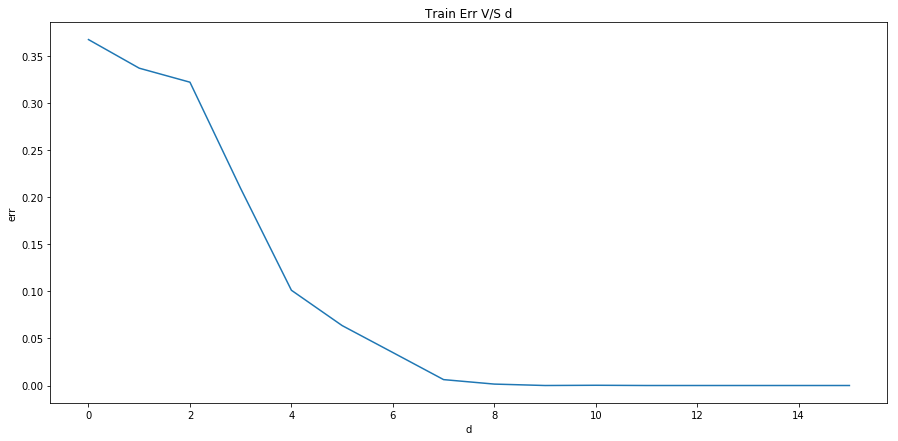

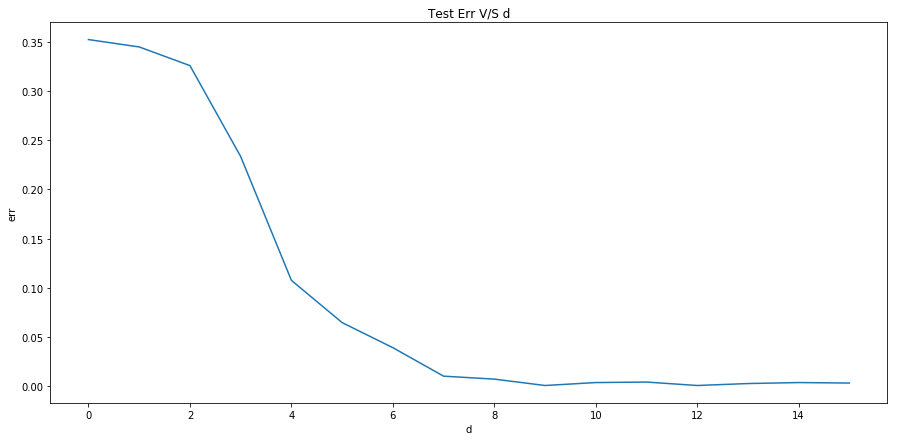

In [43]:
k = 20
m = 10000
split_ratio = 0.8
err_train_list = {}
err_list = {}
sample_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
#sample_list = [0, 1, 2]

for values in sample_list:
    df = dataframe_function(k, m)
    train_df = df.iloc[:int(split_ratio*m)]
    test_df = df.iloc[int(split_ratio*m):]
    
    tree = depth_pruning_decision_tree(train_df, depth=values)
    """print(tree)"""
    err_train_list[values] = compute_ERR(train_df, tree)
    err_list[values] = compute_ERR(test_df, tree)

    
err = sorted(err_train_list.items())
x,y = zip(*err)

plt.plot(x,y)
plt.title('Train Err V/S d')
plt.xlabel('d')
plt.ylabel('err')
plt.show()
    
err = sorted(err_list.items())
x,y = zip(*err)

plt.plot(x,y)
plt.title('Test Err V/S d')
plt.xlabel('d')
plt.ylabel('err')
plt.show()

# Conclusion 

As the depth of the tree increases the error rate on Train set and Test set decreases. As we can see from above plots that there is no much significant change in error rate in d = 8 and d = 10 so we can take d = 8 as a good threshold for d. Which will also improve the computation cost versus when d = 10.

Part b)

**Pruning by Sample Size:** The less data a split is performed on, the less ‘accurate’ we expect the
result of that split to be. Let s be a threshold such that if the data available at a node in your decision
tree is less than or equal to s, you do not split and instead decide Y by simple majority vote (ties broken
by coin flip). Plot, as a function of s, the error on the training set and the error on the testing set for a
tree split down to sample size s. What does your data suggest as a good sample size threshold?

In [44]:
#generate decision tree using pruning by sample
def sample_pruning_decision_tree(dataframe, tree=None, s=0):
    
    #fetch the features X1, X2...Xn
    classes = list(dataframe)[:-1]
    
    #get the node to split on
    split_var = splitting_variable(dataframe)
    
    #initialize tree in form of dictionary if not already initialized
    if tree is None:
        tree = {}
        tree[split_var] = {}
    
    #Explore when split_var is 0 & 1
    for value in (0,1):
        
        if len(dataframe) <= s:
            counts = np.bincount(dataframe['Y'])
            if counts[0] == counts[1]:
                tree[split_var][value] = int(np.random.choice([1,0], 1, p=[0.5, 0.5]))
            else:
                tree[split_var][value] = np.argmax(counts)
            return tree
        
        split_dataframe = dataframe[dataframe[split_var] == value]
        class_value, value_count = np.unique(split_dataframe['Y'], return_counts=True)
        
        #check if split_dataframe has only single class to consider, if not then explore further
        if len(value_count) == 1: 
            tree[split_var][value] = class_value[0]
        else:
            #recursively call the tree
            tree[split_var][value] = sample_pruning_decision_tree(split_dataframe, s=s)
            
    #return the generated tree
    return tree        

In [45]:
pprint(sample_pruning_decision_tree(dataframe_function(k=20, m=100), s=10))

{'X10': {0: {'X13': {0: 0,
                     1: {'X3': {0: 0,
                                1: {'X8': {0: {'X16': {0: {'X6': {0: 1}},
                                                       1: 0}},
                                           1: 1}}}}}},
         1: {'X5': {0: {'X0': {0: 0,
                               1: {'X13': {0: {'X7': {0: 0}},
                                           1: {'X12': {0: {'X8': {0: 1}},
                                                       1: 1}}}}}},
                    1: {'X0': {0: {'X1': {0: 1}}, 1: 1}}}}}}


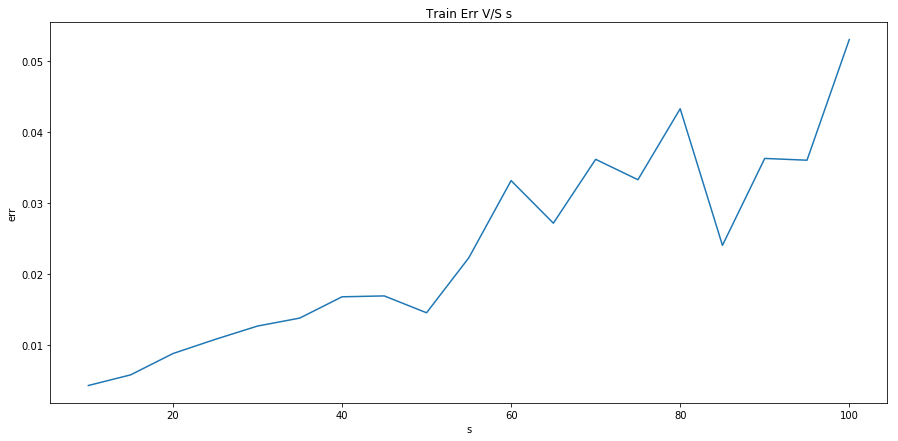

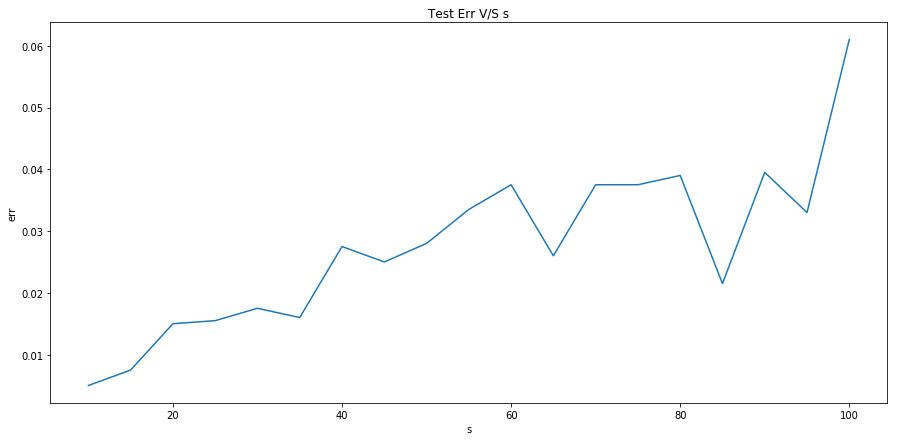

In [46]:
k = 20
m = 10000
split_ratio = 0.8
err_train_list = {}
err_list = {}
sample_list = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
#sample_list = [0, 1, 2]

for values in sample_list:
    df = dataframe_function(k, m)
    train_df = df.iloc[:int(split_ratio*m)]
    test_df = df.iloc[int(split_ratio*m):]
    
    tree = sample_pruning_decision_tree(train_df, s=values)
    """print(tree)"""
    err_train_list[values] = compute_ERR(train_df, tree)
    err_list[values] = compute_ERR(test_df, tree)

    
err = sorted(err_train_list.items())
x,y = zip(*err)

plt.plot(x,y)
plt.title('Train Err V/S s')
plt.xlabel('s')
plt.ylabel('err')
plt.show()
    
err = sorted(err_list.items())
x,y = zip(*err)

plt.plot(x,y)
plt.title('Test Err V/S s')
plt.xlabel('s')
plt.ylabel('err')
plt.show()

# Conclusion 

In the case when we prune the tree based on the sample size of the input, we get the above results for Train and Test Error. We can see that our algorithm best performs when sample size taken is 10, ie having lowest Test error and a negligible amount of training error. Thus we can conclude that our sample size threshold is 10.

Part c)

**Pruning by Significance:** If a variable X is independent of Y , then X has no value as a splitting
variable. We can use something like the χ2-test to estimate how likely a potential splitting variable is
to be independent, based on the test statistic T compared to some threshold T0 (in the usual 2-outcome
case, T0 = 3.841 is used to test at a significance level of p = 5% - see notes for more explanation). Given
T0, if given the data for X the value of T is less than T0, it is deemed not significant and is not used for
splitting. If given the data for X the value of T is greater than T0, it is deemed significant, and used for
splitting. Plot, as a function of T0, the error on the training set and the error on the testing set for a tree
split at significance threshold T0. What does your data suggest as a good threshold for significance?

In [48]:
#generate decision tree using pruning by significance
def significance_pruning_decision_tree(dataframe, tree=None, t0=0):
    
    #fetch the features X1, X2...Xn
    classes = list(dataframe)[:-1]
    
    #get the node to split on
    split_var, t = chi_squared_split(dataframe)

    #initialize tree in form of dictionary if not already initialized
    if tree is None:
        tree = {}
        tree[split_var] = {}
    
    #Explore when split_var is 0 & 1
    for value in (0,1):
        
        if t < t0:
            counts = np.bincount(dataframe['Y'])
            if counts[0] == counts[1]:
                tree[split_var][value] = int(np.random.choice([1,0], 1, p=[0.5, 0.5]))
            else:
                tree[split_var][value] = np.argmax(counts)
            return tree
        
        split_dataframe = dataframe[dataframe[split_var] == value]
        class_value, value_count = np.unique(split_dataframe['Y'], return_counts=True)
        
        #check if split_dataframe has only single class to consider, if not then explore further
        if len(value_count) == 1: 
            tree[split_var][value] = class_value[0]
        else:
            #recursively call the tree
            tree[split_var][value] = significance_pruning_decision_tree(split_dataframe, t0=t0)
            
    #return the generated tree
    return tree        

In [49]:
pprint(significance_pruning_decision_tree(dataframe_function(k=20, m=100), t0=3.841))

{'X5': {0: {'X0': {0: 0,
                   1: {'X13': {0: {'X12': {0: 0, 1: {'X17': {0: 0, 1: 1}}}},
                               1: {'X9': {0: 1}}}}}},
        1: {'X6': {0: {'X2': {0: 0}},
                   1: {'X4': {0: {'X1': {0: {'X2': {0: 0}}, 1: 1}},
                              1: {'X0': {0: 1,
                                         1: {'X8': {0: {'X16': {0: 0, 1: 1}},
                                                    1: 1}}}}}}}}}}


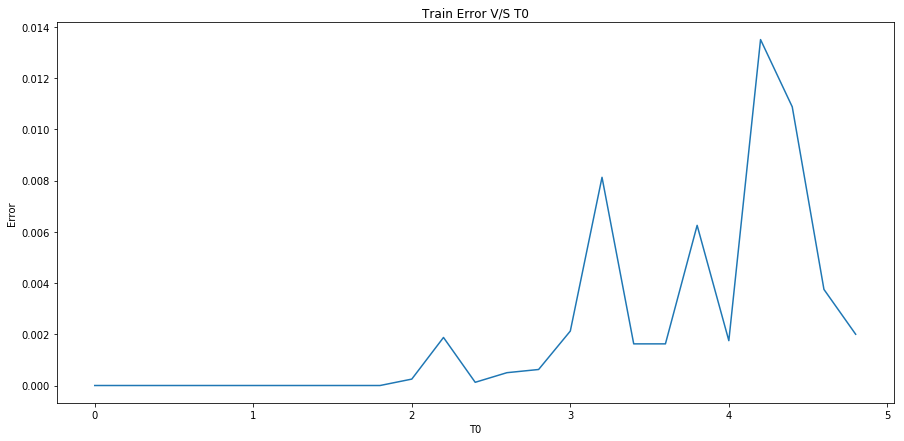

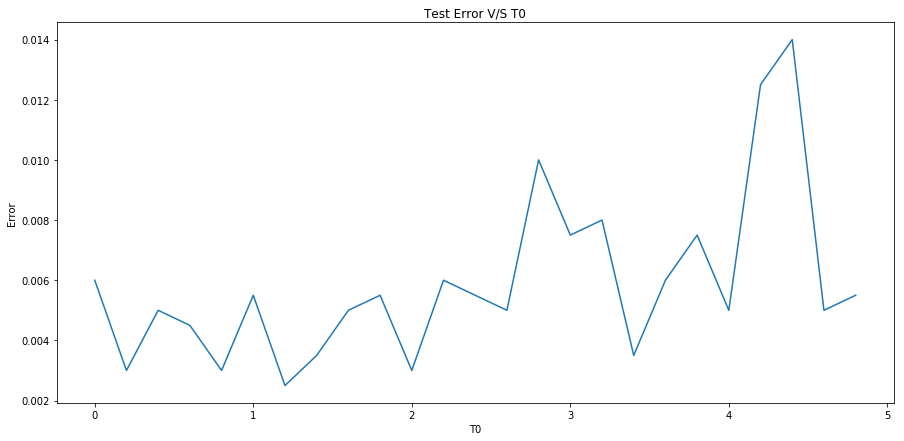

In [55]:
k = 20
m = 10000
split_ratio = 0.8
err_train_list = {}
err_list = {}
sample_list = [0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8]
#sample_list = [0, 1, 2]

for values in sample_list:
    df = dataframe_function(k, m)
    train_df = df.iloc[:int(split_ratio*m)]
    test_df = df.iloc[int(split_ratio*m):]
    
    tree = significance_pruning_decision_tree(train_df, t0=values)
    """print(tree)"""
    err_train_list[values] = compute_ERR(train_df, tree)
    err_list[values] = compute_ERR(test_df, tree)

    
err = sorted(err_train_list.items())
x,y = zip(*err)

plt.plot(x,y)
plt.title('Train Error V/S T0')
plt.xlabel('T0')
plt.ylabel('Error')
plt.show()
    
err = sorted(err_list.items())
x,y = zip(*err)

plt.plot(x,y)
plt.title('Test Error V/S T0')
plt.xlabel('T0')
plt.ylabel('Error')
plt.show()

# Conclusion

By using Chi-Squared Test, when we prune by significance, to check the dependence value between variable and ouput vector. I trained this for various threshold of T value for Chi-Squared Test and the results for Train and Test set are ploted above. From the plot we can see that for value of T0 = 2.15 we have the least Train and Test Error. Hence we can conclude that our algorithm works best for threshold value of T0 = 2.15

# Answer 5

Repeat the computation of Problem 2, growing your trees only to depth d as chosen in 3.a. How does this
change the likelihood or frequency of including spurious variables in your trees?

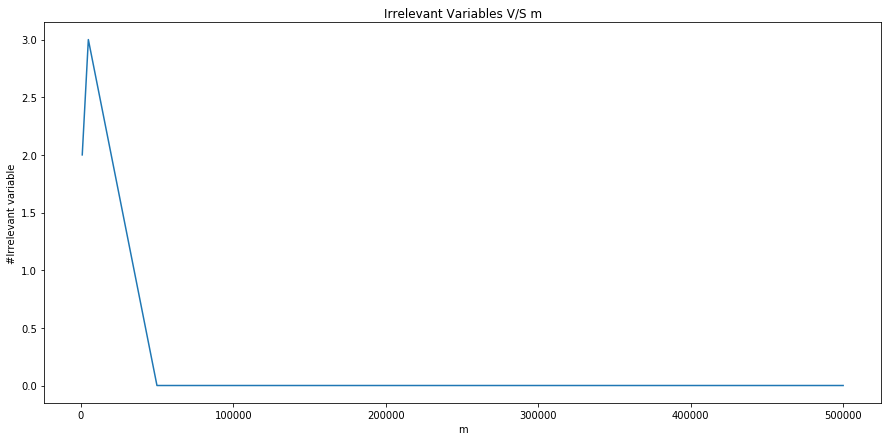

Average number of Irrelevant Variables:  1.0


In [56]:
irrelevant = ["'X15'", "'X16'", "'X17'", "'X18'", "'X19'", "'X20'"]
k = 20
#m = [10, 50, 100, 200, 400, 600, 800, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
m = [1000, 5000, 50000, 100000, 500000]
split_ratio = 0.8
irr_count = {}
depth = 8

for values in m:
    df = dataframe_function(k, values)
    train_df = df.iloc[:int(split_ratio*values)]
    test_df = df.iloc[int(split_ratio*values):]

    tree = depth_pruning_decision_tree(train_df, depth=depth)

    #count irrelevant variable in current decision tree
    variable_list = str(tree)
    count = 0
    for irr in irrelevant:
        if irr in variable_list:
            count += 1

    irr_count[values] = count

irr_list = sorted(irr_count.items())
x,y = zip(*irr_list)

plt.plot(x,y)
plt.title('Irrelevant Variables V/S m')
plt.xlabel('m')
plt.ylabel('#Irrelevant variable')
plt.show()

average_irrelevant_variable = sum(y)/len(y)
print('Average number of Irrelevant Variables: ', average_irrelevant_variable)

# Conclusion
On an average we are getting around 1 irrelevant variable when m is less than 10000 and as the value of m increases the count of irrelevant variables in our decision tree drops to 0. This is observed when we prune our decision tree using depth d = 8.

# Answer 6

Repeat the computation of Problem 2, splitting your trees only to sample size s as chosen in 3.b. How does
this change the likelihood or frequency of including spurious variables in your trees?


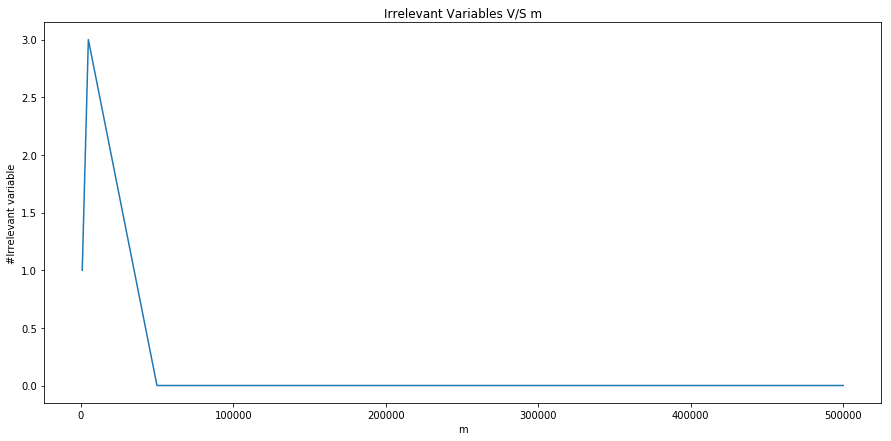

Average number of Irrelevant Variables:  0.8


In [57]:
irrelevant = ["'X15'", "'X16'", "'X17'", "'X18'", "'X19'", "'X20'"]
k = 20
#m = [10, 50, 100, 200, 400, 600, 800, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
m = [1000, 5000, 50000, 100000, 500000]
split_ratio = 0.8
irr_count = {}
sample = 10

for values in m:
    df = dataframe_function(k, values)
    train_df = df.iloc[:int(split_ratio*values)]
    test_df = df.iloc[int(split_ratio*values):]

    tree = sample_pruning_decision_tree(train_df, s=sample)

    #count irrelevant variable in current decision tree
    variable_list = str(tree)
    count = 0
    for irr in irrelevant:
        if irr in variable_list:
            count += 1

    irr_count[values] = count

irr_list = sorted(irr_count.items())
x,y = zip(*irr_list)

plt.plot(x,y)
plt.title('Irrelevant Variables V/S m')
plt.xlabel('m')
plt.ylabel('#Irrelevant variable')
plt.show()

average_irrelevant_variable = sum(y)/len(y)
print('Average number of Irrelevant Variables: ', average_irrelevant_variable)

# Conclusion
On an average we are getting around 1 irrelevant variable when m is less than 50000 and as the value of m increases the count of irrelevant variables in our decision tree drops to 0. This is observed when we prune our decision tree using sample size = 10.

# Answer 7

Repeat the computation of Problem 2, splitting your trees only at or above threshold level T0 as chosen in 3.c.
How does this change the likelihood or frequency of including spurious variables in your trees?

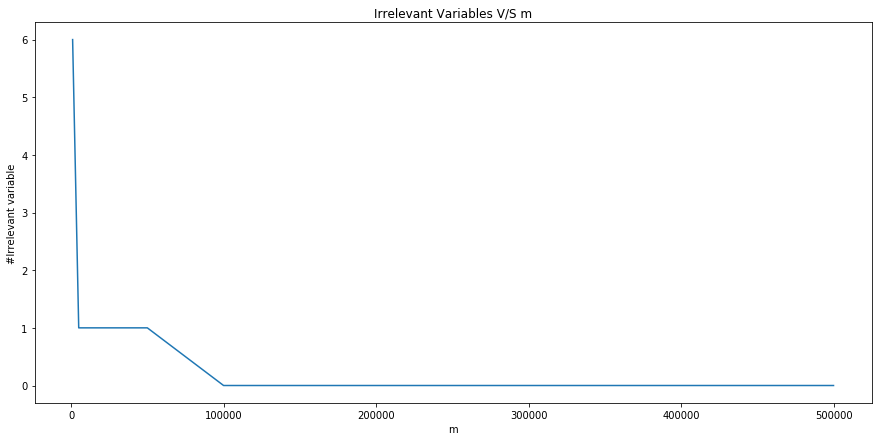

Average number of Irrelevant Variables:  1.6


In [58]:
irrelevant = ["'X15'", "'X16'", "'X17'", "'X18'", "'X19'", "'X20'"]
k = 20
#m = [10, 50, 100, 200, 400, 600, 800, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
m = [1000, 5000, 50000, 100000, 500000]
split_ratio = 0.8
irr_count = {}
t0 = 2.2

for values in m:
    df = dataframe_function(k, values)
    train_df = df.iloc[:int(split_ratio*values)]
    test_df = df.iloc[int(split_ratio*values):]

    tree = significance_pruning_decision_tree(train_df, t0=t0)

    #count irrelevant variable in current decision tree
    variable_list = str(tree)
    count = 0
    for irr in irrelevant:
        if irr in variable_list:
            count += 1

    irr_count[values] = count

irr_list = sorted(irr_count.items())
x,y = zip(*irr_list)

plt.plot(x,y)
plt.title('Irrelevant Variables V/S m')
plt.xlabel('m')
plt.ylabel('#Irrelevant variable')
plt.show()

average_irrelevant_variable = sum(y)/len(y)
print('Average number of Irrelevant Variables: ', average_irrelevant_variable)

# Conclusion
On an average we are getting around 1.6 irrelevant variable when m is less than 10000 and as the value of m increases the count of irrelevant variables in our decision tree slowly drops to 0. This is observed when we prune our decision tree using T0 = 2.2.
